In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sms
import statsmodels.api as sm
%matplotlib inline
import seaborn as sns
from pandas.plotting import lag_plot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_excel('Airlines+Data.xlsx')

In [3]:
df

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121
...,...,...
91,2002-08-01,405
92,2002-09-01,355
93,2002-10-01,306
94,2002-11-01,271


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       96 non-null     datetime64[ns]
 1   Passengers  96 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


In [5]:
df.isnull().sum()

Month         0
Passengers    0
dtype: int64

In [6]:
df.duplicated().sum()

0

In [7]:
df.describe()

,Passengers
count,96.000000
mean,213.708333
std,71.918216
min,104.000000
25%,156.000000
50%,200.000000
75%,264.750000
max,413.000000


In [8]:
df.rename({'Month':'Date'}, axis=1, inplace=True)
df.head()

,Date,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121


In [9]:
df['Date'] = pd.to_datetime(df.Date, format='%b-%y')
df['month'] = df.Date.dt.strftime('%b')
df['year'] = df.Date.dt.strftime('%Y')
df.head()

,Date,Passengers,month,year
0,1995-01-01,112,Jan,1995
1,1995-02-01,118,Feb,1995
2,1995-03-01,132,Mar,1995
3,1995-04-01,129,Apr,1995
4,1995-05-01,121,May,1995


In [10]:
df.set_index('Date', inplace=True)
df.index.year

Int64Index([1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995, 1995,
            1995, 1996, 1996, 1996, 1996, 1996, 1996, 1996, 1996, 1996, 1996,
            1996, 1996, 1997, 1997, 1997, 1997, 1997, 1997, 1997, 1997, 1997,
            1997, 1997, 1997, 1998, 1998, 1998, 1998, 1998, 1998, 1998, 1998,
            1998, 1998, 1998, 1998, 1999, 1999, 1999, 1999, 1999, 1999, 1999,
            1999, 1999, 1999, 1999, 1999, 2000, 2000, 2000, 2000, 2000, 2000,
            2000, 2000, 2000, 2000, 2000, 2000, 2001, 2001, 2001, 2001, 2001,
            2001, 2001, 2001, 2001, 2001, 2001, 2001, 2002, 2002, 2002, 2002,
            2002, 2002, 2002, 2002, 2002, 2002, 2002, 2002],
           dtype='int64', name='Date')

In [11]:
df

,Passengers,month,year
Date,,,
1995-01-01,112,Jan,1995
1995-02-01,118,Feb,1995
1995-03-01,132,Mar,1995
1995-04-01,129,Apr,1995
1995-05-01,121,May,1995
...,...,...,...
2002-08-01,405,Aug,2002
2002-09-01,355,Sep,2002
2002-10-01,306,Oct,2002


<Axes: xlabel='Date'>

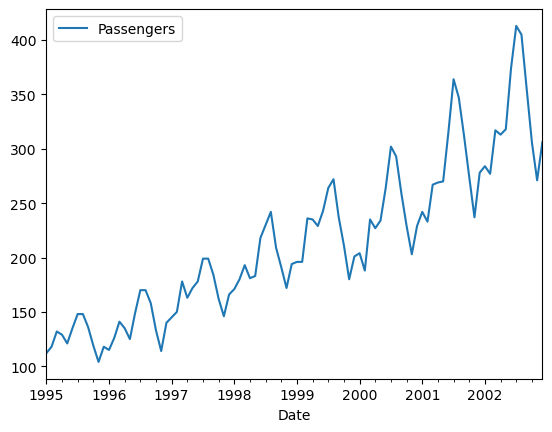

In [12]:
df.plot()

<Axes: >

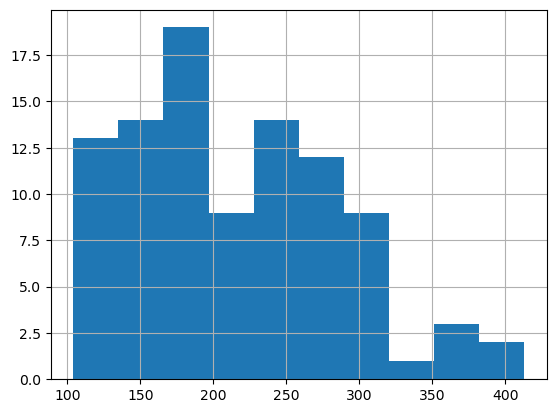

In [13]:
df.Passengers.hist()

<Axes: xlabel='month', ylabel='year'>

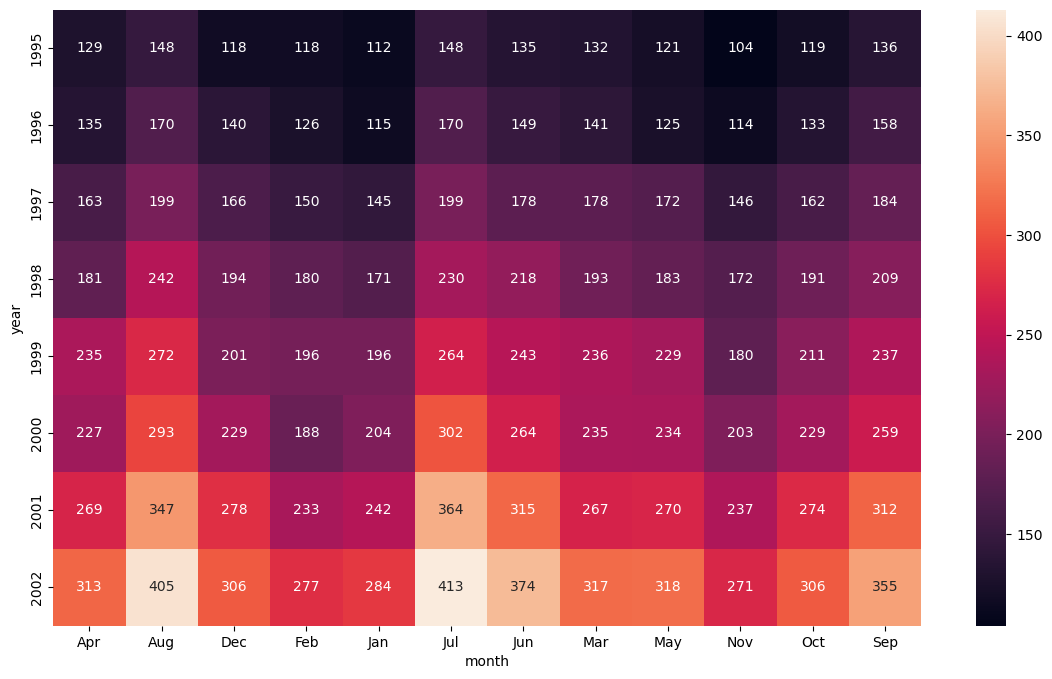

In [14]:
plt.figure(figsize=(14,8))
y_month = pd.pivot_table(data=df, values='Passengers', index='year', columns='month', aggfunc='mean',fill_value=0)
sns.heatmap(y_month, annot=True, fmt='2g')

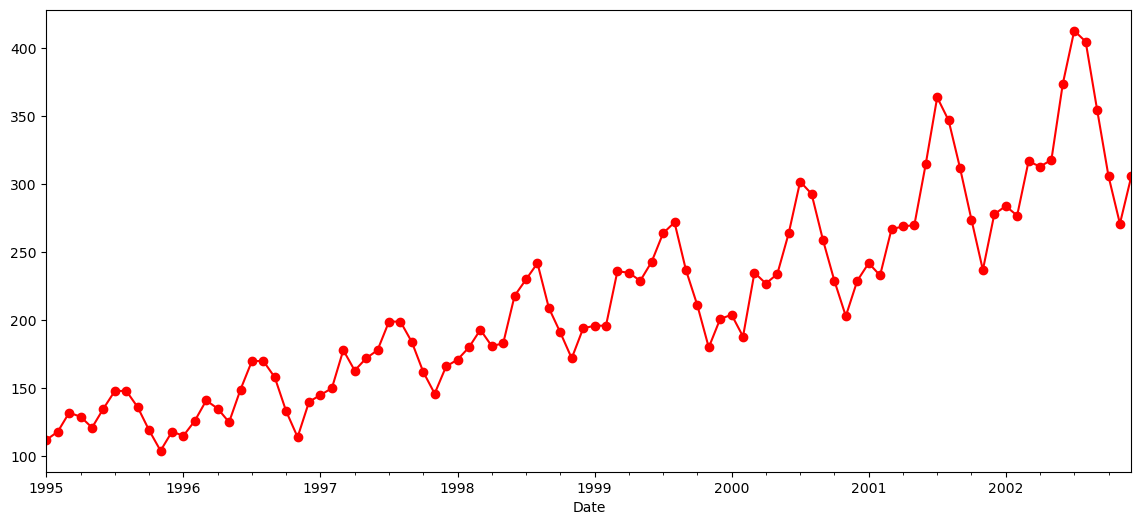

In [15]:
df['Passengers'].plot(figsize=(14,6),color='red',marker='o')
plt.show()

<Axes: ylabel='Density'>

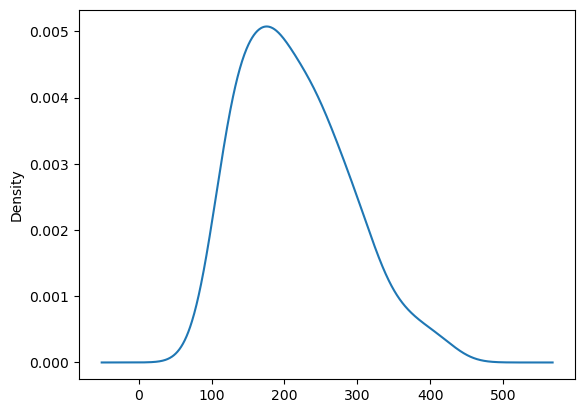

In [16]:
#Density plot and Lag plot

df.Passengers.plot(kind='kde')

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

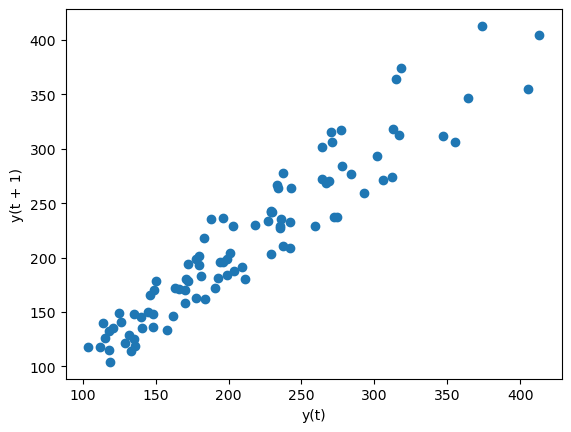

In [17]:
lag_plot(df.Passengers)

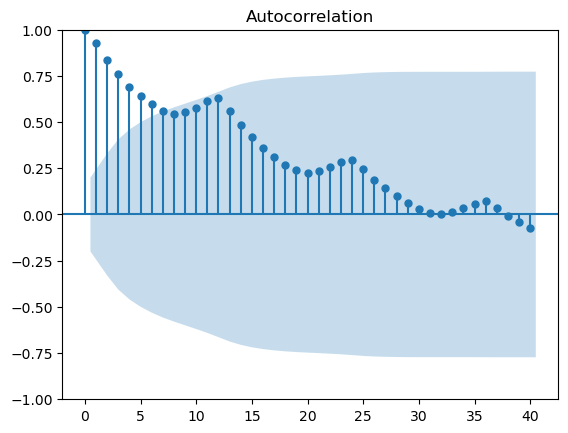

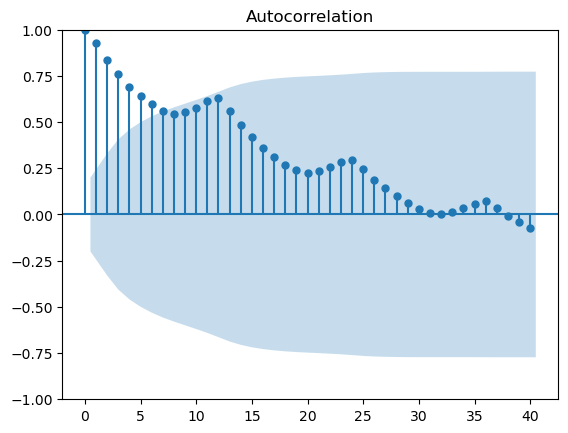

In [18]:
# create an autocorrelation plot

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df.Passengers,lags=40)

<Axes: xlabel='year', ylabel='Passengers'>

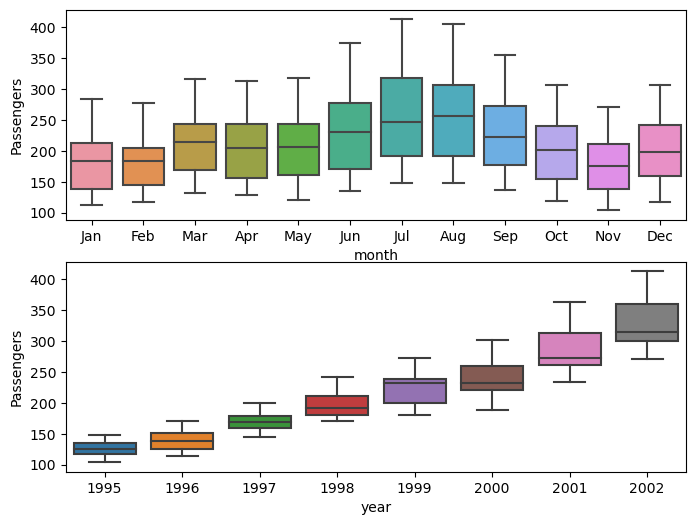

In [19]:
# Boxplot 

plt.figure(figsize=(8,6))
plt.subplot(211)
sns.boxplot(x="month",y="Passengers",data=df)

plt.subplot(212)
sns.boxplot(x="year",y="Passengers",data=df)

In [20]:
# Adding 't', 't_square', and 't_log' columns
df['t'] = np.arange(1, len(df) + 1)
df['t_square'] = df['t'] ** 2
df['t_log'] = np.log(df['t'])

In [21]:
# Splitting the data into train and test sets
size = 72
train_data = df[:size]
test_data = df[size:]
print(train_data)
print(test_data)

            Passengers month  year   t  t_square     t_log
Date                                                      
1995-01-01         112   Jan  1995   1         1  0.000000
1995-02-01         118   Feb  1995   2         4  0.693147
1995-03-01         132   Mar  1995   3         9  1.098612
1995-04-01         129   Apr  1995   4        16  1.386294
1995-05-01         121   May  1995   5        25  1.609438
...                ...   ...   ...  ..       ...       ...
2000-08-01         293   Aug  2000  68      4624  4.219508
2000-09-01         259   Sep  2000  69      4761  4.234107
2000-10-01         229   Oct  2000  70      4900  4.248495
2000-11-01         203   Nov  2000  71      5041  4.262680
2000-12-01         229   Dec  2000  72      5184  4.276666

[72 rows x 6 columns]
            Passengers month  year   t  t_square     t_log
Date                                                      
2001-01-01         242   Jan  2001  73      5329  4.290459
2001-02-01         233   Feb  200

In [22]:
# Linear Model
X_train_linear = sm.add_constant(train_data[['t']])
y_train_linear = train_data['Passengers']
linear_model = sm.OLS(y_train_linear, X_train_linear).fit()

In [23]:
# Quadratic Model
X_train_quad = sm.add_constant(train_data[['t', 't_square']])
y_train_quad = train_data['Passengers']
quadratic_model = sm.OLS(y_train_quad, X_train_quad).fit()

In [24]:
# Exponential Model
X_train_exp = sm.add_constant(train_data[['t_log']])
y_train_exp = train_data['Passengers']
exponential_model = sm.OLS(y_train_exp, X_train_exp).fit()

In [25]:
# Predictions on the test set for the Linear Model
X_test_linear = sm.add_constant(test_data[['t']])
pred_linear = linear_model.predict(X_test_linear)

In [26]:
# Predictions on the test set for the Quadratic Model
X_test_quad = sm.add_constant(test_data[['t', 't_square']])
pred_quad = quadratic_model.predict(X_test_quad)

In [27]:
# Predictions on the test set for the Exponential Model
X_test_exp = sm.add_constant(test_data[['t_log']])
pred_exp = exponential_model.predict(X_test_exp)

In [28]:
from sklearn.metrics import mean_squared_error

In [29]:
mse_linear = mean_squared_error(test_data['Passengers'], pred_linear)
mse_quad = mean_squared_error(test_data['Passengers'], pred_quad)
mse_exp = mean_squared_error(test_data['Passengers'], pred_exp)

In [30]:
rmse_linear = np.sqrt(mse_linear)
rmse_quad = np.sqrt(mse_quad)
rmse_exp = np.sqrt(mse_exp)

In [31]:
# Display MSE and RMSE for each model
print("MSE for Linear Model:", mse_linear)
print("RMSE for Linear Model:", rmse_linear)

print("MSE for Quadratic Model:", mse_quad)
print("RMSE for Quadratic Model:", rmse_quad)

print("MSE for Exponential Model:", mse_exp)
print("RMSE for Exponential Model:", rmse_exp)

MSE for Linear Model: 2669.5608330409573
RMSE for Linear Model: 51.6677929956463
MSE for Quadratic Model: 2703.0366715759587
RMSE for Quadratic Model: 51.990736401554834
MSE for Exponential Model: 8342.29193058876
RMSE for Exponential Model: 91.33614799513258


In [32]:
import statsmodels.api as sm

In [33]:
# Additional Seasonality
X_train_add_seasonal = sm.add_constant(train_data[['t']])
X_train_add_seasonal['seasonal'] = np.sin(2 * np.pi * X_train_add_seasonal['t'] / 12)
y_train_add_seasonal = train_data['Passengers']
add_seasonal_model = sm.OLS(y_train_add_seasonal, X_train_add_seasonal).fit()

In [34]:
# Multiplicative Seasonality
X_train_mult_seasonal = sm.add_constant(train_data[['t']])
X_train_mult_seasonal['seasonal'] = np.sin(2 * np.pi * X_train_mult_seasonal['t'] / 12)
y_train_mult_seasonal = train_data['Passengers']
mult_seasonal_model = sm.OLS(np.log(y_train_mult_seasonal), X_train_mult_seasonal).fit()

In [35]:
# Additive Seasonality with Quadratic Terms
X_train_add_quad_seasonal = sm.add_constant(train_data[['t', 't_square']])
X_train_add_quad_seasonal['seasonal'] = np.sin(2 * np.pi * X_train_add_quad_seasonal['t'] / 12)
y_train_add_quad_seasonal = train_data['Passengers']
add_quad_seasonal_model = sm.OLS(y_train_add_quad_seasonal, X_train_add_quad_seasonal).fit()

In [36]:
# Multiplicative Additive Seasonality
X_train_mult_add_seasonal = sm.add_constant(train_data[['t']])
X_train_mult_add_seasonal['seasonal'] = np.sin(2 * np.pi * X_train_mult_add_seasonal['t'] / 12)
y_train_mult_add_seasonal = train_data['Passengers']
mult_add_seasonal_model = sm.OLS(np.log(y_train_mult_add_seasonal), X_train_mult_add_seasonal).fit()

In [37]:
# Predictions on the test set for each model
X_test_add_seasonal = sm.add_constant(test_data[['t']])
X_test_add_seasonal['seasonal'] = np.sin(2 * np.pi * X_test_add_seasonal['t'] / 12)
pred_add_seasonal = add_seasonal_model.predict(X_test_add_seasonal)

In [38]:
X_test_mult_seasonal = sm.add_constant(test_data[['t']])
X_test_mult_seasonal['seasonal'] = np.sin(2 * np.pi * X_test_mult_seasonal['t'] / 12)
pred_mult_seasonal = np.exp(mult_seasonal_model.predict(X_test_mult_seasonal))

In [39]:
X_test_add_quad_seasonal = sm.add_constant(test_data[['t', 't_square']])
X_test_add_quad_seasonal['seasonal'] = np.sin(2 * np.pi * X_test_add_quad_seasonal['t'] / 12)
pred_add_quad_seasonal = add_quad_seasonal_model.predict(X_test_add_quad_seasonal)

In [40]:
X_test_mult_add_seasonal = sm.add_constant(test_data[['t']])
X_test_mult_add_seasonal['seasonal'] = np.sin(2 * np.pi * X_test_mult_add_seasonal['t'] / 12)
pred_mult_add_seasonal = np.exp(mult_add_seasonal_model.predict(X_test_mult_add_seasonal))

In [41]:
# Calculate RMSE for each model
rmse_add_seasonal = np.sqrt(mean_squared_error(test_data['Passengers'], pred_add_seasonal))
rmse_mult_seasonal = np.sqrt(mean_squared_error(test_data['Passengers'], pred_mult_seasonal))
rmse_add_quad_seasonal = np.sqrt(mean_squared_error(test_data['Passengers'], pred_add_quad_seasonal))
rmse_mult_add_seasonal = np.sqrt(mean_squared_error(test_data['Passengers'], pred_mult_add_seasonal))

In [42]:
# Display RMSE for each model
print("RMSE for Additional Seasonality Model:", rmse_add_seasonal)
print("RMSE for Multiplicative Seasonality Model:", rmse_mult_seasonal)
print("RMSE for Additive Seasonality with Quadratic Model:", rmse_add_quad_seasonal)
print("RMSE for Multiplicative Additive Seasonality Model:", rmse_mult_add_seasonal)

RMSE for Additional Seasonality Model: 51.17350622087436
RMSE for Multiplicative Seasonality Model: 41.35693987397227
RMSE for Additive Seasonality with Quadratic Model: 51.417181423522806
RMSE for Multiplicative Additive Seasonality Model: 41.35693987397227


In [43]:
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    if result[1] <= 0.05:
       print("Strong evidence against the null hypothesis,reject the null hypothesis.Data has no unit root and is stationary")
    else:
       print("Weak evidence against null hypothesis,time series has unit root , indicating it is non -statinary")

In [44]:
adf_test(df['Passengers'])

ADF Statistics: 1.3402479596466974
p-value: 0.9968250481137263
Weak evidence against null hypothesis,time series has unit root , indicating it is non -statinary


* p-value: 0.9968250481137263 indicating data is not stationary.

In [45]:
df['Passengers First Difference']=df['Passengers']-df['Passengers'].shift(1)
df.head()

,Passengers,month,year,t,t_square,t_log,Passengers First Difference
Date,,,,,,,
1995-01-01,112,Jan,1995,1,1,0.000000,NaN
1995-02-01,118,Feb,1995,2,4,0.693147,6.0
1995-03-01,132,Mar,1995,3,9,1.098612,14.0
1995-04-01,129,Apr,1995,4,16,1.386294,-3.0
1995-05-01,121,May,1995,5,25,1.609438,-8.0


In [46]:
adf_test(df['Passengers First Difference'].dropna())

ADF Statistics: -2.15000173592066
p-value: 0.22488942647512306
Weak evidence against null hypothesis,time series has unit root , indicating it is non -statinary


* Data is still not stationary.

* using second differencing technique

In [47]:
df['Passengers Second Difference'] = df['Passengers First Difference']-df['Passengers First Difference'].shift(1)

adf_test(df['Passengers Second Difference'].dropna())

ADF Statistics: -11.547980944840836
p-value: 3.50318023632083e-21
Strong evidence against the null hypothesis,reject the null hypothesis.Data has no unit root and is stationary


* Data is  stationary.

* we are checking for over a year now  ( we are looking for seasonal differences now and sometimes ARIMA doesnot work well for seasonal data but SARIMAX Does )
* Seasonality Differencing Graph 

In [48]:
df['Passengers 12 Difference']=df['Passengers']-df['Passengers'].shift(12)
adf_test(df['Passengers 12 Difference'].dropna())

ADF Statistics: -2.6900043838623167
p-value: 0.07578397625851754
Weak evidence against null hypothesis,time series has unit root , indicating it is non -statinary


* ARIMA is not working well for seasonal data in this scenario"""

* Plotting   the acf and pacf  gives the argument values for arima function

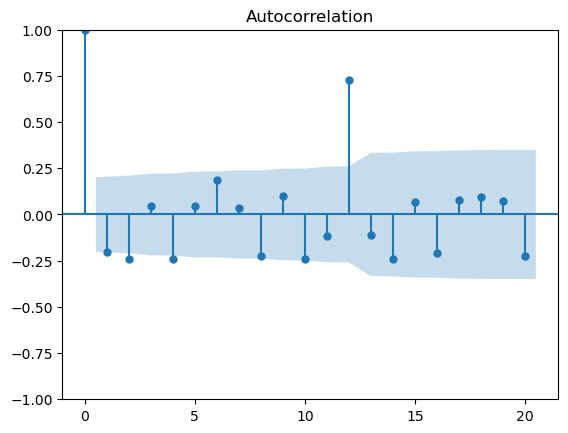

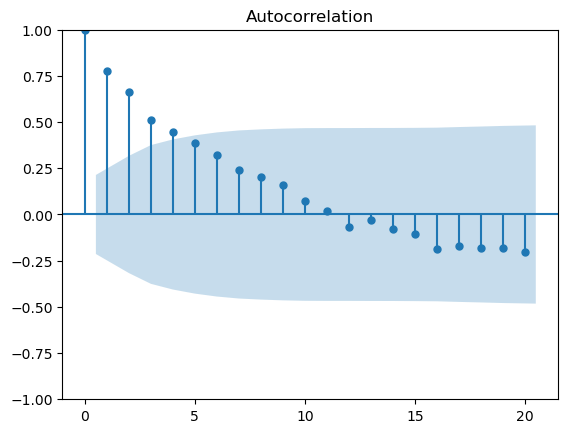

In [49]:
acf = plot_acf(df['Passengers Second Difference'].dropna())

acf12 = plot_acf(df['Passengers 12 Difference'].dropna())

,Passengers,month,year,t,t_square,t_log,Passengers First Difference,Passengers Second Difference,Passengers 12 Difference
Date,,,,,,,,,
1995-01-01,112,Jan,1995,1,1,0.000000,NaN,NaN,NaN
1995-02-01,118,Feb,1995,2,4,0.693147,6.0,NaN,NaN
1995-03-01,132,Mar,1995,3,9,1.098612,14.0,8.0,NaN
1995-04-01,129,Apr,1995,4,16,1.386294,-3.0,-17.0,NaN
1995-05-01,121,May,1995,5,25,1.609438,-8.0,-5.0,NaN
...,...,...,...,...,...,...,...,...,...
2002-08-01,405,Aug,2002,92,8464,4.521789,-8.0,-47.0,58.0
2002-09-01,355,Sep,2002,93,8649,4.532599,-50.0,-42.0,43.0
2002-10-01,306,Oct,2002,94,8836,4.543295,-49.0,1.0,32.0


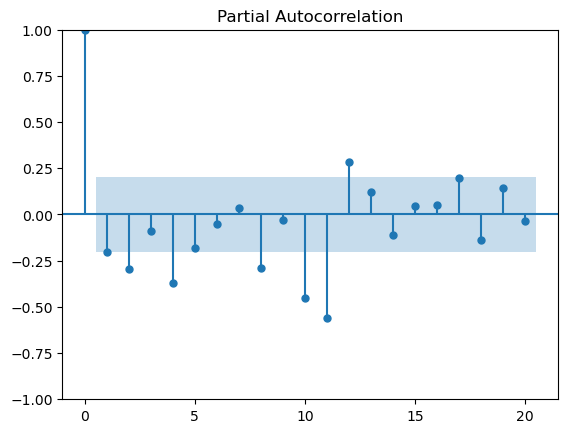

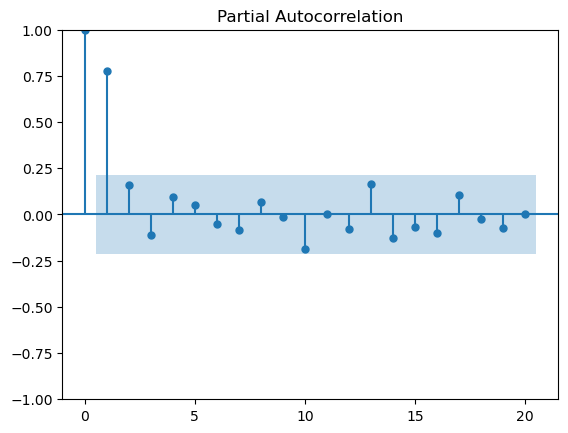

In [50]:
pacf = plot_pacf(df['Passengers Second Difference'].dropna())

pacf12 = plot_pacf(df['Passengers 12 Difference'].dropna())

df

In [51]:
model = ARIMA(train_data['Passengers'], order=(11, 2, 2))
model_fit = model.fit()

2001-01-01    225.801923
2001-02-01    214.078984
2001-03-01    245.573213
2001-04-01    246.551767
2001-05-01    256.187690
2001-06-01    285.232876
2001-07-01    319.964563
2001-08-01    312.278137
2001-09-01    283.313967
2001-10-01    253.468686
2001-11-01    230.230088
2001-12-01    253.039363
2002-01-01    248.726370
2002-02-01    238.356810
2002-03-01    259.113590
2002-04-01    265.522590
2002-05-01    278.014994
2002-06-01    306.350630
2002-07-01    338.016218
2002-08-01    331.326528
2002-09-01    306.999204
2002-10-01    277.940817
2002-11-01    257.810775
2002-12-01    276.569593
Freq: MS, Name: predicted_mean, dtype: float64

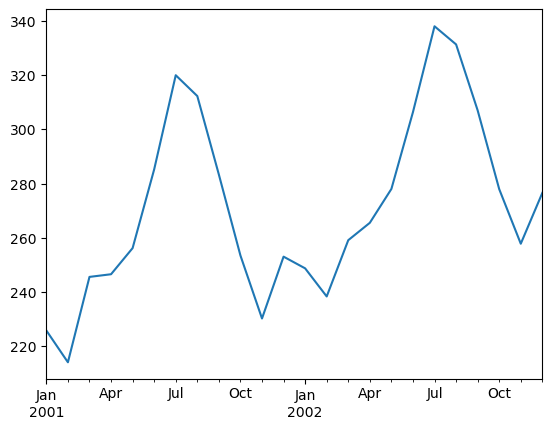

In [52]:
# Make predictions on the testing set
predictions = model_fit.forecast(steps=len(test_data))

predictions.plot()

predictions

In [53]:
# Check the shape of the input arrays
if test_data['Passengers'].shape[0] > 1 and predictions.shape[0] > 1:
    # Calculate the mean squared error
    mse = mean_squared_error(test_data['Passengers'], predictions)

    # Calculate the root mean squared error
    rmse = np.sqrt(mse)
    print('RMSE:', rmse)
else:
    print('Error: Input arrays have only one element')

RMSE: 39.485145496699275


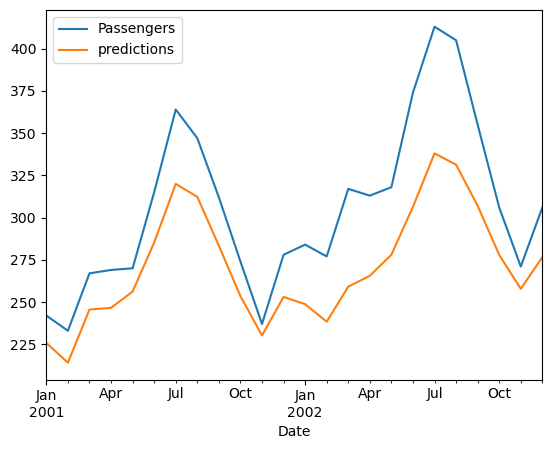

In [54]:
model_fit.summary()
test_data['predictions'] = predictions 

test_data[['Passengers','predictions']].plot() 
plt.show()

In [55]:
"""  SARIMAX   """
# Fit SARIMA model
model_SARIMA = SARIMAX(train_data['Passengers'], order=(11, 2, 2), seasonal_order=(0, 0, 0, 12))
model_SARIMA_fit = model_SARIMA.fit()

In [56]:
# Make predictions on the testing set
predictions_SARIMA = model_SARIMA_fit.forecast(steps=len(test_data))

In [57]:
# Check the shape of the input arrays
if test_data['Passengers'].shape[0] > 1 and predictions_SARIMA.shape[0] > 1:
    # Calculate the mean squared error
    mse = mean_squared_error(test_data['Passengers'], predictions_SARIMA)

    # Calculate the root mean squared error
    rmse = np.sqrt(mse)
    print('RMSE:', rmse)
else:
    print('Error: Input arrays have only one element')

RMSE: 39.485145496699275


In [58]:
# Display model summary
model_SARIMA_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Passengers   No. Observations:                   72
Model:              SARIMAX(11, 2, 2)   Log Likelihood                -265.059
Date:                Fri, 19 Jan 2024   AIC                            558.117
Time:                        10:33:16   BIC                            589.596
Sample:                    01-01-1995   HQIC                           570.621
                         - 12-01-2000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8399      0.195     -4.304      0.000      -1.222      -0.457
ar.L2         -0.8913      0.098     -9.063      0.000      -1.084      -0.699
ar.L3         -0.8689      0.136     -6.399      0.000      -1.135      -0.603
ar.L4         -0.8770      0.121     -7.258      0.000      -1.114      -0.640
ar.L5         -0.8021      0.138     -5.796      0.000      -1.073      -0.531
ar.L6         -0.8422      0.102     -8.245      0.000      -1.042      -0.642
ar.L7         -0.8138      0.136     -6.004      0.000      -1.079      -0.548
ar.L8         -0.9287      0.102     -9.128      0.000      -1.128      -0.729
ar.L9         -0.8231      0.115     -7.171      0.000      -1.048      -0.598
ar.L10        -0.9046      0.098     -9.218      0.000      -1.097      -0.712
ar.L11        -0.7738      0.133     -5.833      0.000      -1.034      -0.514
ma.L1         -0.3906      0.259     -1.506      0.132      -0.899       0.118
ma.L2         -0.0329      0.260     -0.126      0.899      -0.543       0.478
sigma2        89.0655     19.622      4.539      0.000      50.608     127.523
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 6.60
Prob(Q):                              0.88   Prob(JB):                         0.04
Heteroskedasticity (H):               3.39   Skew:                             0.73
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [59]:
# Add predictions to test_data
test_data['predictions_SARIMA'] = predictions_SARIMA

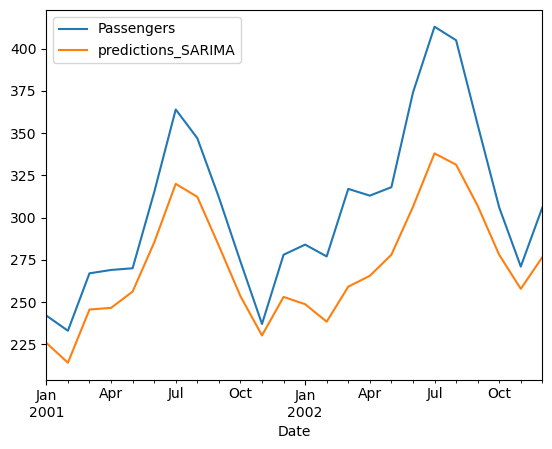

In [60]:
# Plot actual vs predicted values
test_data[['Passengers', 'predictions_SARIMA']].plot()
plt.show()

In [61]:
# Fit ARIMA model
model_ARIMA = ARIMA(train_data['Passengers'], order=(3, 0, 5))
model_ARIMA_fit = model_ARIMA.fit()
predictions_ARIMA = model_ARIMA_fit.forecast(steps=len(test_data))

In [62]:
# Fit SARIMA model
model_SARIMA = SARIMAX(train_data['Passengers'], order=(3, 0, 5), seasonal_order=(0, 1, 0, 12))
model_SARIMA_fit = model_SARIMA.fit()
predictions_SARIMA = model_SARIMA_fit.forecast(steps=len(test_data))

In [63]:
# Calculate RMSE for ARIMA
mse_ARIMA = mean_squared_error(test_data['Passengers'], predictions_ARIMA)
rmse_ARIMA = np.sqrt(mse_ARIMA)
print('RMSE (ARIMA):', rmse_ARIMA)

RMSE (ARIMA): 93.63687361202851


In [64]:
# Calculate RMSE for SARIMA
mse_SARIMA = mean_squared_error(test_data['Passengers'], predictions_SARIMA)
rmse_SARIMA = np.sqrt(mse_SARIMA)
print('RMSE (SARIMA):', rmse_SARIMA)

RMSE (SARIMA): 43.48557609291209


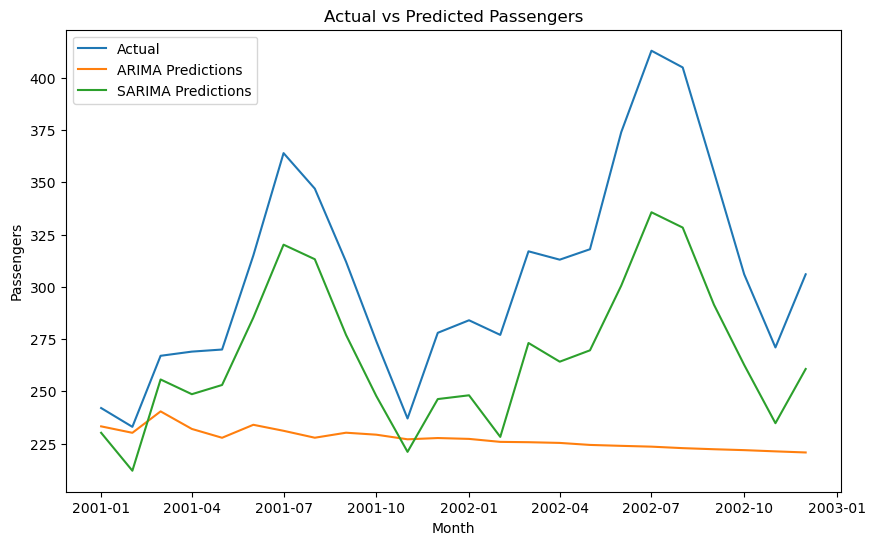

In [65]:
# Plot actual vs predicted values for both models
plt.figure(figsize=(10, 6))
plt.plot(test_data['Passengers'], label='Actual')
plt.plot(predictions_ARIMA, label='ARIMA Predictions')
plt.plot(predictions_SARIMA, label='SARIMA Predictions')
plt.legend()
plt.title('Actual vs Predicted Passengers')
plt.xlabel('Month')
plt.ylabel('Passengers')
plt.show()

*  SARIMA MODEL GIVES US THE BETTER RESULTS THAN REST OF THE MODELS APPLIED FOR GIVEN DATASET